In [14]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [15]:
from dotenv import load_dotenv


load_dotenv()

True

In [16]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [17]:

groq_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [18]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

In [19]:
response=groq_model.invoke("hi")


In [20]:
response.content


'<think>\n\n</think>\n\nHello! How can I assist you today?'

In [21]:

clean_text(response.content)

'Hello! How can I assist you today?'

In [22]:
tavaily_tool=TavilySearchResults()


In [23]:
tavaily_tool.invoke("what is a gdp?")


[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetarymeasure of the total market value( of all the final goods and services produced and rendered in a specific time period by a country( or countries.( GDP is often used to measure the economic performance of a country or region.( Several national and international economic organizations maintain definitions of GDP, such as the OECD and the International Monetary Fund.( [...] GDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\n\nY = C + I + G + (X − M)\nHere is a description of each GDP component: [...] Sustainability of growth – GDP is a measurement of economic historic activity and is not necessarily a projection.\n   Income distribution – GDP does not account for variances in incomes of various demographic groups. See income inequality metrics for discussion of a 

In [24]:

code = """
x = 5
y = x * 2
print(y)
"""

In [25]:

repl=PythonREPL()

In [26]:

repl.run(code)

'10\n'

In [27]:

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [28]:
print(python_repl_tool.invoke(code))


Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [29]:
members=["researcher","coder"]


In [30]:
options=members+["FINISH"]


In [31]:

options

['researcher', 'coder', 'FINISH']

In [32]:

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [33]:

class State(MessagesState):
    next:str

In [34]:

system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

[{"role": "system", "content": system_prompt},]


[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [35]:

state={"next":["hi"]}


In [36]:

state["next"]

['hi']

In [37]:
[{"role": "system", "content": system_prompt},] + state["next"]


[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [38]:

def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = groq_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [39]:

def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(groq_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [40]:

def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [41]:
graph=StateGraph(State)


In [42]:
graph.add_node("supervisor",supervisor_node)


In [43]:
graph.add_node("researcher", research_node)


In [44]:
graph.add_node("coder", code_node)


In [45]:
graph.add_edge(START,"supervisor")


In [46]:
app=graph.compile()


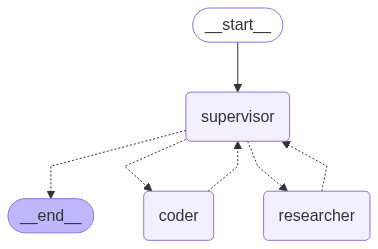

In [47]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [48]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:9bdd6c51-0253-a3b5-9d86-52f221faf20a',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.48.', additional_kwargs={'reasoning_content': "Okay, so I'm trying to figure out the square root of 42. I remember that the square root of a number is a value that, when multiplied by itself, gives the original number. So, for 42, I'm looking for a number that, when squared, equals 42.\n\nFirst, I think about perfect squares near 42. I know that 6 squared is 36 and 7 squared is 49. Since 42 is between 36 and 49, the square root must be between 6 and 7. But I need a more precise value.\n\nI recall that 6.5 squared is 42.25 because 6.5 times 6.5 is 42.25. That’s very close to 42, so the square root of 42 should be just a little less than 6.5. Maybe around 6.48 or something.\n\nI also remember that calculators can give precise square roots, but 

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


below my goto**********************************
FINISH
((), {'supervisor': {'next': '__end__'}})
----


In [49]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)


below my goto**********************************
researcher


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


below my goto**********************************
FINISH


{'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='6d88b97c-8618-490e-9b2f-878745f978c8'),
  HumanMessage(content='The square root of 42 is approximately 6.4807. This is a rounded value, as the exact square root of 42 is an irrational number.', additional_kwargs={}, response_metadata={}, name='researcher', id='b4237be7-4a5d-4c3b-a17b-42f3f144f219')],
 'next': '__end__'}

In [ ]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)


below my goto**********************************
researcher
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
researcher
below my goto**********************************
coder
